In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [12]:
df = pd.read_excel(r"C:\Users\sk062\Downloads\merge_df.xlsx")

In [13]:
df.head()

,地域,2023年度 待機児童,A1101_総人口【人】,A1201_0～4歳人口【人】,保育所等数（基本票）,保育所数÷子供の人数,総教員数,園長,副園長,教頭,主幹教諭,指導教諭,教諭,助教諭,養護教諭,養護助教諭,栄養教諭,講師,教育補助員
0,北海道,62,5092000,142000,1099,0.006072,704,17,5,1,4,0,460,101,5,0,8,103,265
1,青森県,0,1184000,32000,472,0.014750,73,10,0,0,0,0,44,3,1,0,2,13,48
2,岩手県,27,1163000,32000,391,0.012219,131,12,1,0,0,0,92,2,3,0,0,21,71
3,宮城県,41,2264000,69000,515,0.007464,476,28,3,0,3,2,359,5,15,0,0,61,146
4,秋田県,3,914000,22000,268,0.012182,48,5,1,0,1,0,27,0,0,0,0,14,28


In [14]:
# 指標づくり
df_ratios = df.copy()
df_ratios['施設あたりの子供数'] = df_ratios['A1201_0～4歳人口【人】'] / df_ratios['保育所等数（基本票）']
df_ratios['教員一人あたりの子供数'] = df_ratios['A1201_0～4歳人口【人】'] / df_ratios['総教員数']
df_ratios['施設あたりの教員数'] = df_ratios['総教員数'] / df_ratios['保育所等数（基本票）']

In [15]:
df_ratios.head()

,地域,2023年度 待機児童,A1101_総人口【人】,A1201_0～4歳人口【人】,保育所等数（基本票）,保育所数÷子供の人数,総教員数,園長,副園長,教頭,...,教諭,助教諭,養護教諭,養護助教諭,栄養教諭,講師,教育補助員,施設あたりの子供数,教員一人あたりの子供数,施設あたりの教員数
0,北海道,62,5092000,142000,1099,0.006072,704,17,5,1,...,460,101,5,0,8,103,265,129.208371,201.704545,0.640582
1,青森県,0,1184000,32000,472,0.014750,73,10,0,0,...,44,3,1,0,2,13,48,67.796610,438.356164,0.154661
2,岩手県,27,1163000,32000,391,0.012219,131,12,1,0,...,92,2,3,0,0,21,71,81.841432,244.274809,0.335038
3,宮城県,41,2264000,69000,515,0.007464,476,28,3,0,...,359,5,15,0,0,61,146,133.980583,144.957983,0.924272
4,秋田県,3,914000,22000,268,0.012182,48,5,1,0,...,27,0,0,0,0,14,28,82.089552,458.333333,0.179104


In [16]:
print(df_ratios.describe())

       2023年度 待機児童  A1101_総人口【人】  A1201_0～4歳人口【人】   保育所等数（基本票）  保育所数÷子供の人数  \
count    47.000000  4.700000e+01        47.000000    47.000000   47.000000   
mean     57.021277  2.645809e+06     87063.829787   645.914894    0.012531   
std      97.292810  2.797551e+06     93444.799854   616.423585    0.023506   
min       0.000000  5.370000e+05     19000.000000   187.000000    0.000462   
25%       0.000000  1.034000e+06     31500.000000   299.000000    0.006481   
50%      10.000000  1.549000e+06     56000.000000   439.000000    0.007607   
75%      58.500000  2.636500e+06     83000.000000   662.000000    0.011180   
max     411.000000  1.408600e+07    461000.000000  3615.000000    0.164318   

              総教員数          園長        副園長         教頭       主幹教諭  ...  \
count    47.000000   47.000000  47.000000  47.000000  47.000000  ...   
mean    514.595745   23.425532   5.085106   1.553191   1.340426  ...   
std     597.879247   26.846378   7.912098   3.229002   2.379958  ...   
min      

In [17]:
new_corr_columns = ['2023年度 待機児童', '施設あたりの子供数', '教員一人あたりの子供数', '施設あたりの教員数']
new_correlation = df_ratios[new_corr_columns].corr()
new_correlation

,2023年度 待機児童,施設あたりの子供数,教員一人あたりの子供数,施設あたりの教員数
2023年度 待機児童,1.000000,0.389105,-0.175890,0.258846
施設あたりの子供数,0.389105,1.000000,-0.508153,0.762797
教員一人あたりの子供数,-0.175890,-0.508153,1.000000,-0.717439
施設あたりの教員数,0.258846,0.762797,-0.717439,1.000000


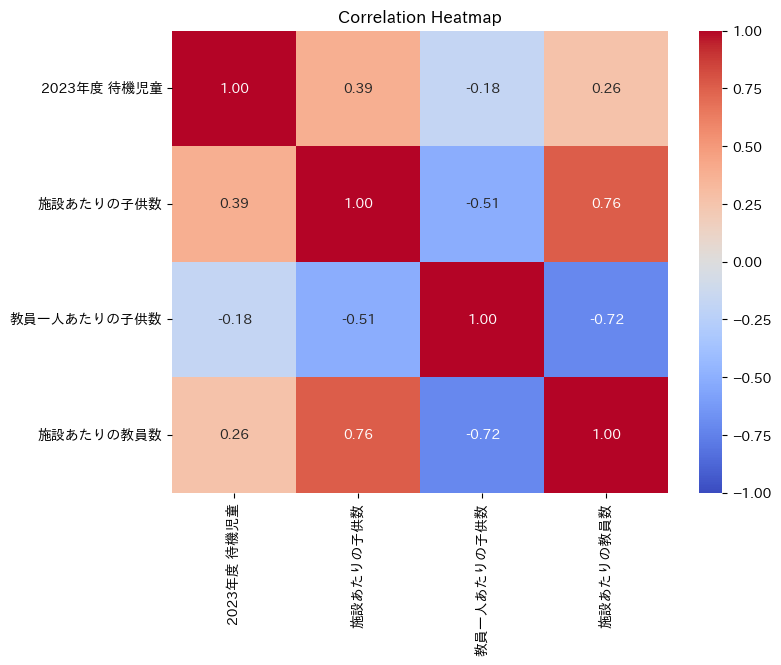

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(new_correlation, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [24]:
# 重回帰分析(OLS)
X_multi = df_ratios[[ '施設あたりの子供数', '教員一人あたりの子供数', '施設あたりの教員数']]
y = df_ratios["2023年度 待機児童"]

X_multi_sm = sm.add_constant(X_multi)
model_ols = sm.OLS(y,X_multi).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            2023年度 待機児童   R-squared (uncentered):                   0.350
Model:                            OLS   Adj. R-squared (uncentered):              0.305
Method:                 Least Squares   F-statistic:                              7.885
Date:                Sat, 23 Aug 2025   Prob (F-statistic):                    0.000256
Time:                        11:26:28   Log-Likelihood:                         -278.30
No. Observations:                  47   AIC:                                      562.6
Df Residuals:                      44   BIC:                                      568.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
施設あたりの子供数       0.8607      0.520      1.656      0.105      -0.187       1.908
教員一人あたりの子供数    -0.1174      0.109     -1.082      0.285      -0.336       0.101
施設あたりの教員数     -26.7946     60.110     -0.446      0.658    -147.938      94.349
==============================================================================
Omnibus:                       38.657   Durbin-Watson:                   1.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.101
Skew:                           2.335   Prob(JB):                     1.83e-22
Kurtosis:                       8.413   Cond. No.                     1.30e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

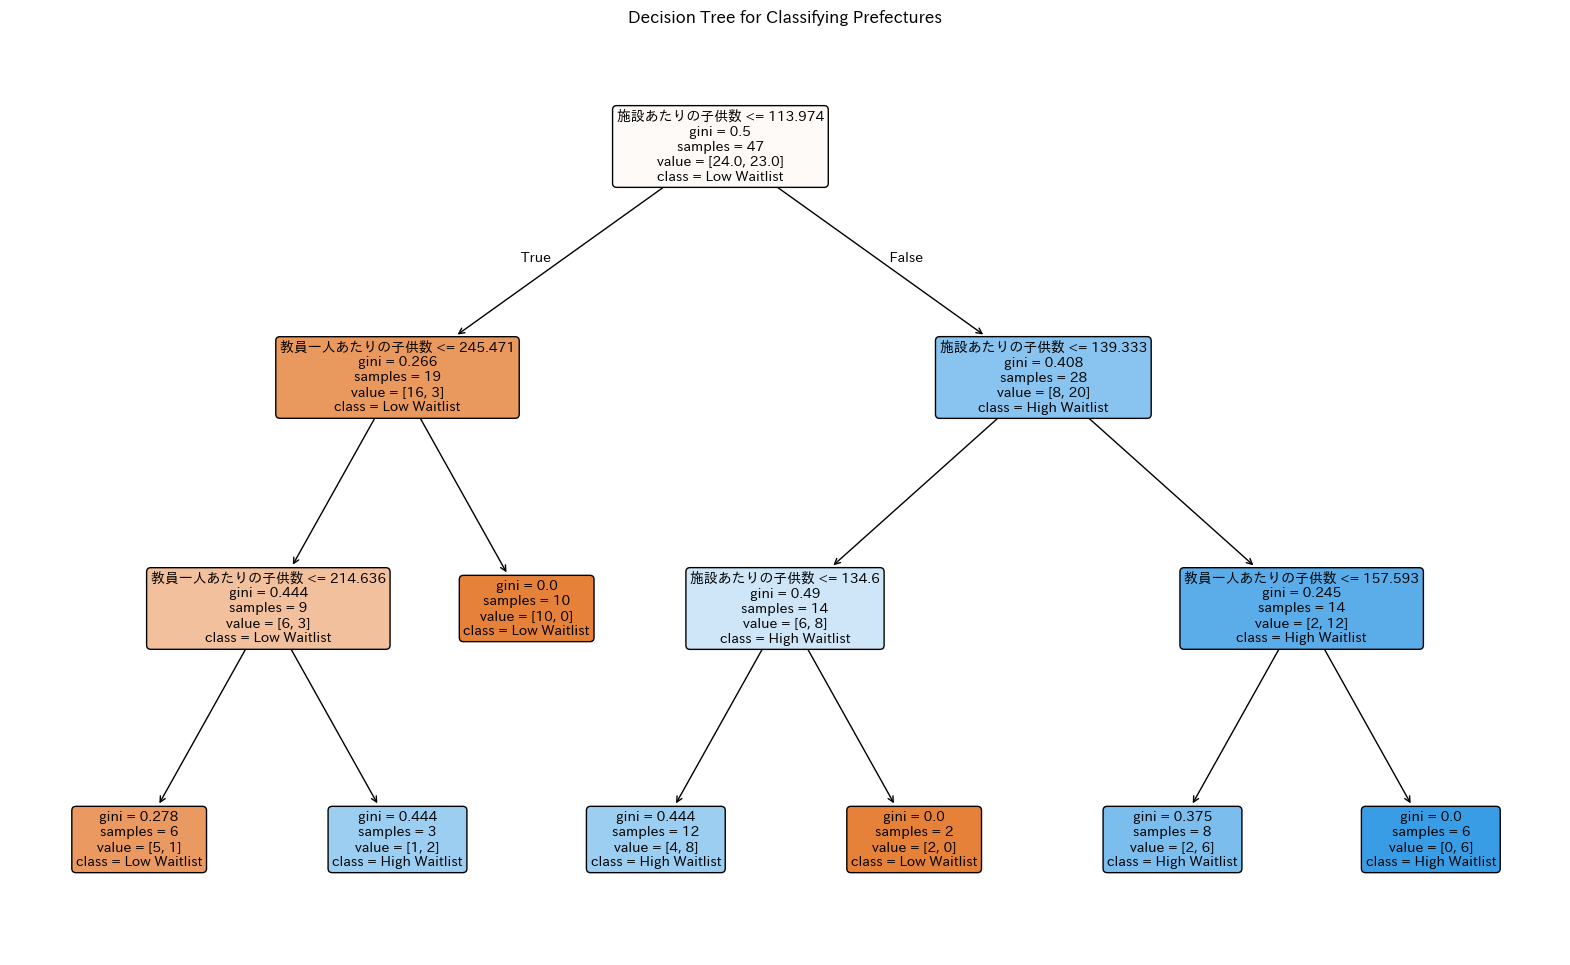

In [25]:
waitlist_median = df_ratios['2023年度 待機児童'].median()
df_ratios['target_class'] = (df_ratios['2023年度 待機児童'] > waitlist_median).astype(int)
X_tree = df_ratios[['施設あたりの子供数', '教員一人あたりの子供数',"施設あたりの教員数"]]
y_tree = df_ratios['target_class']
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42).fit(X_tree, y_tree)
plt.figure(figsize=(20, 12))
plot_tree(dt_classifier, feature_names=X_tree.columns, class_names=['Low Waitlist', 'High Waitlist'], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree for Classifying Prefectures")
plt.show()

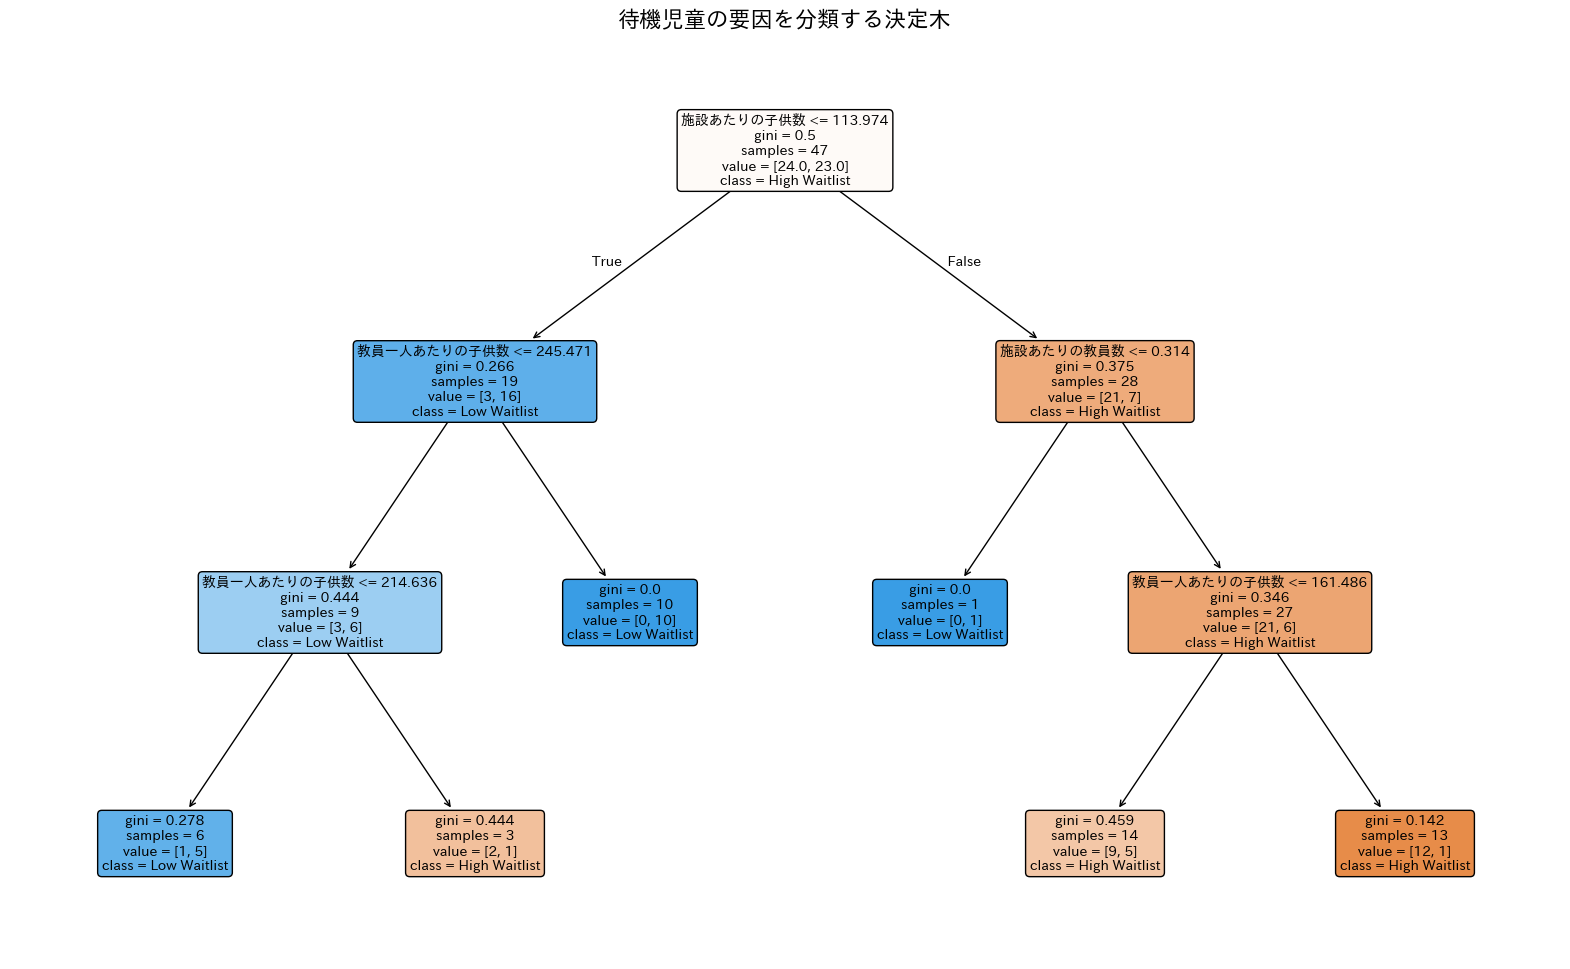

--- 特徴量の重要度 ---
施設あたりの子供数      0.649772
教員一人あたりの子供数    0.254714
施設あたりの教員数      0.095514
dtype: float64




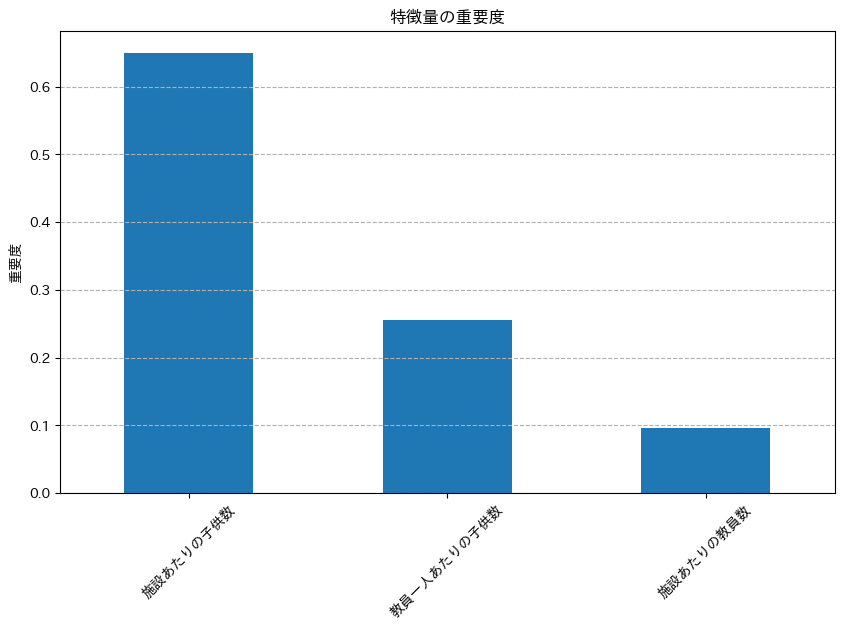

KeyError: 'leaf_id'

In [26]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語表示のためのライブラリ

# 待機児童数の中央値を基準に「多い(High)」「少ない(Low)」のラベルを付与
waitlist_median = df_ratios['2023年度 待機児童'].median()
df_ratios['target_class'] = np.where(df_ratios['2023年度 待機児童'] >= waitlist_median, 'High Waitlist', 'Low Waitlist')

# Step 2: モデルの学習
# 説明変数(X)と目的変数(y)を定義
X = df_ratios[['施設あたりの子供数', '教員一人あたりの子供数', '施設あたりの教員数']]
y = df_ratios['target_class']

# 決定木分類器のインスタンス化と学習
# max_depthを3に設定して、木の深さを制限し解釈しやすくします
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_classifier.fit(X, y)

# Step 3: 決定木の可視化
plt.figure(figsize=(20, 12))
plot_tree(dt_classifier, 
          feature_names=X.columns, 
          class_names=dt_classifier.classes_, # クラス名を学習器から取得
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("待機児童の要因を分類する決定木", fontsize=16)
plt.show()


# Step 4: さらに踏み込んだ分析
# 4-1. 特徴量の重要度を確認する
importances = pd.Series(dt_classifier.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("--- 特徴量の重要度 ---")
print(importances)
print("\n")

plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('特徴量の重要度')
plt.ylabel('重要度')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


# 4-2. 各都道府県がどの課題を持つかを分析する
# 各データがどの葉ノードに分類されたかを取得
leaf_ids = dt_classifier.apply(X)
df['leaf_id'] = leaf_ids

# 各葉ノードの分類結果（'High' or 'Low'）を取得
# dt_classifier.tree_.value[leaf_id][0] は、その葉ノードの各クラスのサンプル数を含む配列
# argmaxで最もサンプル数が多いクラスのインデックスを取得
leaf_class = {leaf_id: dt_classifier.classes_[np.argmax(dt_classifier.tree_.value[leaf_id][0])] for leaf_id in np.unique(leaf_ids)}
df_ratios['predicted_class'] = df_ratios['leaf_id'].map(leaf_class)

# 各都道府県の課題を分析する関数
def get_decision_path_rules(tree, feature_names, sample):
    """
    特定のサンプルが決定木をたどるルールを文字列として返す関数
    """
    node_indicator = tree.decision_path(sample)
    leaf_id = tree.apply(sample)
    feature = tree.feature
    threshold = tree.threshold
    
    path_rules = []
    node_index = node_indicator.indices[node_indicator.indices != leaf_id[0]]
    
    for node_id in node_index:
        if sample[0, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
            
        rule = f"{feature_names[feature[node_id]]} {threshold_sign} {threshold[node_id]:.2f}"
        path_rules.append(rule)
        
    return " → ".join(path_rules)

# 各都道府県の分類ルールをDataFrameに追加
df_ratios['decision_path'] = [get_decision_path_rules(dt_classifier.tree_, X.columns, X.loc[pref].values.reshape(1, -1)) for pref in df.index]

# 結果の表示（待機児童が多いと予測された地域に絞って表示）
print("--- 待機児童が多い(High Waitlist)と分類された地域の分析 ---")
high_waitlist_df = df_ratios[df_ratios['predicted_class'] == 'High Waitlist']
print(high_waitlist_df[['predicted_class', 'decision_path', '施設あたりの子供数', '教員一人あたりの子供数', '施設あたりの教員数']])